# Using Comparative Players To Inform Contract Decision Making

This notebook is used to explore how to look at players who had similar seasons to Trey Hendrickson and see if that data can help predict Trey's future production and perhaps even inform target contract details.

In [351]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn import linear_model

sys.path.append("../..")

from utils import get_def_player_stats, get_players_info, get_contract_data

TREY_HENDRICKSON_ID = '00-0033935'

### Finding Comparative Players

It seems that some kind of clustering analysis can be done to find some number of players who have had seasons similar to Trey. Trey's next contract will largely be based on his performance for the past two seasons, his age, and how well he fits into a specific defense's strategy. There is a lot of data that I don't have access to that would enable more nuanced metrics (e.g. [STRAIN](https://arxiv.org/abs/2305.10262)). So this analysis is not meant to suggest any real-world usefulness.

I'll break this problem down into multiple steps:
1. Min/Max Scale the statistics for all players in each season. (e.g. the most sacks in a season will receive value of 1, and the least will receive 0)
2. Calculate a rolling average of two seasons for each player. 
3. Use a clustering algorithm to find a number of players who had similar two season averages.
4. Evaluate the next contracts each of those players had.
5. Produce a predictive performance model for Trey given the average of comparative players.

### 0) Load initial data and aggregate as needed

In [352]:
def_df = get_def_player_stats(list(range(1999, 2025)))

# Post season stats would skew things
def_df = def_df[(def_df["season_type"] == "REG")]

def_df = def_df.rename(columns={"week": "games"})

# Add some players specific information
players_df = get_players_info()
def_df["birth_date"] = def_df["player_id"].map(
    players_df.set_index("gsis_id")["birth_date"], na_action="ignore"
)
def_df["entry_year"] = def_df["player_id"].map(
    players_df.set_index("gsis_id")["entry_year"], na_action="ignore"
)
def_df["status"] = def_df["player_id"].map(
    players_df.set_index("gsis_id")["status"], na_action="ignore"
)

# Anyone missing a birth date probably isn't in the stats anyways but let's filter out
def_df = def_df[def_df["birth_date"].notna()]

# Calculate the estimated age for each season. Could consider doing this by week
def_df["age"] = def_df["season"] - pd.DatetimeIndex(def_df["birth_date"]).year

de_df = def_df[(def_df["position"] == "DE")]

# Only use columns I care about
def_df = def_df[
    [
        "player_id",
        "season",
        "games",
        "player_display_name",
        "def_tackles",
        "def_sacks",
        "def_tackles_for_loss",
        "def_qb_hits",
        "def_interceptions",
        "age",
        "status"
    ]
]

def_df = def_df.groupby(["player_id", "season"]).agg(
    {
        "player_display_name": "max",
        "age": "max",
        "games": "count",
        "def_sacks": "sum",
        "def_tackles": "sum",
        "def_tackles_for_loss": "sum",
        "def_qb_hits": "sum",
        "def_interceptions": "sum",
        "status": "max"
    }
)

### 1) Min/Max Scale


In [353]:
pivot_df = def_df
pivot_df = pivot_df.reset_index()
pivot_df = pivot_df.pivot(index='player_id', columns='season', values=['def_sacks', 'def_tackles', 'def_tackles_for_loss', 'def_qb_hits', 'def_interceptions']).fillna(0)
normalized_df=(pivot_df-pivot_df.min())/(pivot_df.max()-pivot_df.min())
normalized_df.sample(5)

def_sacks                                                    ...  \
season          1999 2000 2001 2002 2003 2004 2005      2006 2007 2008  ...   
player_id                                                               ...   
00-0023678       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
00-0031307       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
00-0021200       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
00-0023621       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.060606  0.0  0.0  ...   
00-0026763       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  ...   

           def_interceptions                                                    
season                  2015 2016 2017      2018 2019 2020 2021 2022 2023 2024  
player_id                                                                       
00-0023678               0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  
00-0031307               0.0  0.0  0.0  0.142857  0.0  0.0  0.0  0.0  0.0  0.0  
00-0021200               0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  
00-0023621               0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  
00-0026763               0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 130 columns]

### 2) Calculate rolling 2 season window

In [354]:
unpivot_df = normalized_df.stack(level=1).fillna(0)

# Remove any player/seasons with all zeros
unpivot_df = unpivot_df[(unpivot_df != 0).any(axis=1)]

# remove any players that only have one season of data
unpivot_df = unpivot_df[unpivot_df.index.get_level_values(0).map(unpivot_df.index.get_level_values(0).value_counts()) > 1]

#  Average the rolling two seasons of data for each player
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
unpivot_df = unpivot_df.groupby(level=0, group_keys=False).apply(lambda x: x.rolling(window=indexer, min_periods=1).mean()).dropna()

# Drop the last season of data for each player
unpivot_df = unpivot_df.groupby(level=0).apply(lambda x: x.iloc[:-1]).reset_index(level=0, drop=True)
unpivot_df.head()

def_sacks  def_tackles  def_tackles_for_loss  def_qb_hits  \
player_id  season                                                              
00-0000008 1999     0.029412     0.290797              0.095238     0.033333   
00-0000017 1999     0.060606     0.465506              0.071429     0.076923   
           2000     0.000000     0.317276              0.045549     0.000000   
           2001     0.000000     0.329779              0.046739     0.000000   
           2002     0.000000     0.246237              0.025000     0.000000   

                   def_interceptions  
player_id  season                     
00-0000008 1999             0.071429  
00-0000017 1999             0.866071  
           2000             0.737500  
           2001             0.550000  
           2002             0.305556

In [355]:
# combine the player_id and season into a single index
final_df = unpivot_df
final_df.index = final_df.index.set_names(['player_id', 'season'])

### 3) Clustering Analysis

I didn't experiment with any other clustering algorithms as I've used AgglomerativeClustering before and felt it would be a fine algorithm for this use case. It may be interesting to test that out though.

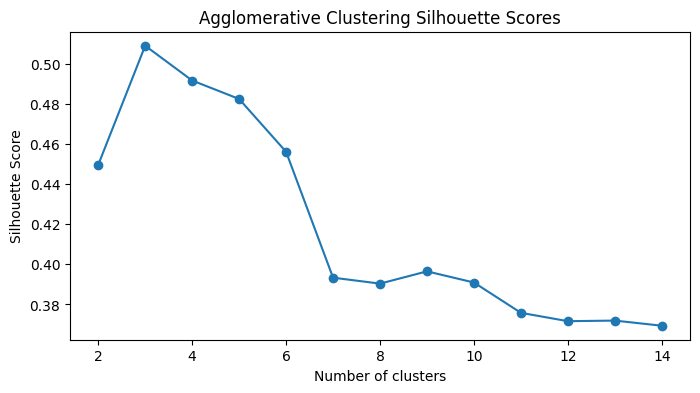

In [356]:
from sklearn.cluster import AgglomerativeClustering

# from 1 to 20 clusters test the silhouette score and plot the final restults
from sklearn.metrics import silhouette_score
scores = []
range_n_clusters = range(2, 15)
for n_clusters in range_n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(final_df)
    score = silhouette_score(final_df, labels)
    scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Agglomerative Clustering Silhouette Scores')
plt.show()


Given how many players we have I don't really like the idea of using a number of clusters based on silhouette score. I think Trey was grouped with about 80 other players when I used 5 clusters. So I explored using a `distance_threshold` instead which resulted in getting a number of players that were easier to reason about. I haven't fully thought through the statistical implications, but it feels justified to use a hierachical clustering like this to just pick the "nearest players".

In [357]:
# Final clustering - I used a fixed distance_threshold and tweaked it until I got a reasonable number of players in Trey's cluster
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=.4, compute_full_tree=True)
labels = clustering.fit_predict(final_df)
score = silhouette_score(final_df, labels)
print(f'Silhouette Score: {score}')

# map all labels to the player names
label_map = {}
for i, player_id in enumerate(final_df.index):
    label_map[player_id] = labels[i]

# Trey Hendrickson's label (2023 and 2024 season stats)
trey_label = label_map[(TREY_HENDRICKSON_ID, 2023)]

# Players with same cluster label as Trey Hendrickson
trey_cluster_players = [player_id for player_id, label in label_map.items() if label == trey_label]

# Names of the players in the same cluster as Trey Hendrickson
trey_cluster_names = def_df[def_df.index.isin(trey_cluster_players)]

Silhouette Score: 0.26082029038992866


The final silhouette score was not a great value. This suggests there isn't great differentiation in clusters overall, but maybe the cluster specifically for Trey Hendrickson is still useful. Let's take a look.

In [358]:
trey_cluster_names

player_display_name  age  games  def_sacks  def_tackles  \
player_id  season                                                           
00-0014358 1999           Warren Sapp   27     15       12.5           27   
00-0015795 2000       Michael Strahan   29     16        9.5           51   
           2001       Michael Strahan   30     16       22.5           60   
00-0022695 2010           Jason Babin   30     16       12.5           44   
00-0023445 2008         DeMarcus Ware   26     16       20.0           69   
           2009         DeMarcus Ware   27     16       11.0           45   
00-0031388 2017          Aaron Donald   26     14       11.0           32   
00-0033886 2023             T.J. Watt   29     17       19.0           47   
00-0033935 2023      Trey Hendrickson   29     17       17.5           28   
00-0035717 2022             Nick Bosa   25     16       18.5           41   

                   def_tackles_for_loss  def_qb_hits  def_interceptions status  
player_id  season                                                               
00-0014358 1999                      13          9.0                0.0    RET  
00-0015795 2000                      15         11.0                0.0    RET  
           2001                      23         18.0                0.0    RET  
00-0022695 2010                      16         26.0                0.0    CUT  
00-0023445 2008                      27         26.0                0.0    RES  
           2009                       9         22.0                0.0    RES  
00-0031388 2017                      15         27.0                0.0    RET  
00-0033886 2023                      19         36.0                1.0    ACT  
00-0033935 2023                      16         25.0                0.0    ACT  
00-0035717 2022                      19         48.0                0.0    ACT

This turns out to be pretty useful. For the players and seasons Trey matched on we see Defensive Player of the Year nominations and winners, Pro Bowlers, and All Pros. This lines up with Trey's last two years.

### 4) Evaluate the contracts for the comparative players

In [359]:
# So the 4 other players who have had a similar two season run to Trey Hendrickson are listed above.
# Let's get the salary / contract data for those players
contract_df = get_contract_data()[['player', 'gsis_id', 'year_signed', 'years', 'inflated_value', 'inflated_guaranteed', 'inflated_apy', 'date_of_birth']]

# I had to find Nick Bosa's and TJ Watt's birth day manually
contract_df.loc[contract_df['gsis_id'] == '00-0035717', 'date_of_birth'] = 'October 23, 1997'
contract_df.loc[contract_df['gsis_id'] == '00-0033886', 'date_of_birth'] = 'October 11, 1994'

# I used this area to get specific ideas. The group of indices are in the next cell
# trey_cluster_contracts = contract_df[contract_df['gsis_id'].isin([player_id for player_id, season in trey_cluster_players])]
# contract_df[contract_df['player'] == 'Warren Sapp']
# contract_df[contract_df['player'] == 'Michael Strahan']
# contract_df[contract_df['player'] == 'Michael Strahan']
# contract_df[contract_df['player'] == 'T.J. Watt']


In [360]:
# Could be interesting to automatically figure out the right contracts to pull but I just pulled the indices from above
# * Warren Sapps 2004 contract is a couple years after his best seasons but it's the best comparator
trey_comparisons = contract_df.loc[[23640, 28332, 28543, 28390, 23724, 28358, 28333]]

# subtract birth year from season signed to get age at signing
trey_comparisons['age'] = trey_comparisons['year_signed'] - pd.DatetimeIndex(trey_comparisons['date_of_birth']).year
trey_comparisons.drop(columns=['date_of_birth', 'gsis_id'])

,player,year_signed,years,inflated_value,inflated_guaranteed,inflated_apy,age
23640,Aaron Donald,2018,6.0,212.708804,78.781038,35.451467,27
28332,Nick Bosa,2023,5.0,211.138790,109.295374,42.227758,26
28543,Jason Babin,2011,5.0,65.697529,12.756802,13.139506,31
28390,Michael Strahan,2002,6.0,150.388906,61.250357,25.064818,31
23724,Warren Sapp,2004,7.0,126.811447,15.591571,18.115919,32
28358,DeMarcus Ware,2009,6.0,177.053659,58.089889,29.508943,27
28333,T.J. Watt,2025,3.0,123.000000,108.000000,41.000000,31


In [367]:
# Bootstrap 1000 samples and then get the 80% middle range
bootstrapped_means = []

for _ in range(1000):
    sample = trey_comparisons.sample(frac=1, replace=True)
    bootstrapped_means.append(sample[['years', 'inflated_value', 'inflated_guaranteed', 'inflated_apy', 'age']].mean())

bootstrapped_means = pd.DataFrame(bootstrapped_means)
mean_contract_values = bootstrapped_means.quantile(0.1), bootstrapped_means.quantile(0.9)


# mean_contract_values = trey_comparisons[['years', 'inflated_value', 'inflated_guaranteed', 'inflated_apy', 'age']].mean()
mean_contract_values

(years                    4.857143
 inflated_value         127.808103
 inflated_guaranteed     46.203882
 inflated_apy            24.223695
 age                     28.142857
 Name: 0.1, dtype: float64,
 years                    6.000000
 inflated_value         176.438316
 inflated_guaranteed     81.854105
 inflated_apy            34.550381
 age                     30.428571
 Name: 0.9, dtype: float64)

The inflated values provided by NFLVerse data was nice. I think another method could be to look at the contract rankings of the players by position. (For example after Aaron Donald signed how many player's at that position made more money than he did in 2018) and then apply that same calculation to today. This could help account for how differently positions can be valued as the game and talent changes over the seasons. 

Given the data above though I'm not sure I'd do anything statistically. I'd find a way to present that data perhaps alongside current contract data.

### 4b) Continue to look at overall contract data for defensive ends.

In [361]:
# Only use defensive ends in contract data
active_de_players = de_df[(de_df['games'] > 14) & (de_df['season'] >= 2020)]
all_de_contracts = contract_df[contract_df['player'].isin(active_de_players['player_display_name'].unique())]

# Drop any players who only have one contract in the dataset
all_de_contracts = all_de_contracts.groupby('player').filter(lambda x: len(x) > 1)

# gsis_id is missing for some players so we'll group by player name
# Get last contract for each player
last_contract = all_de_contracts.sort_values('year_signed').groupby('player').nth(-1)
recent_long_term_de_contracts = last_contract[(last_contract['year_signed'] > 2020) & (last_contract['years'].astype(int) > 2)]['inflated_guaranteed']

recent_long_term_de_contracts


player
A'Shawn Robinson          8.062255
Arik Armstead            30.609240
Broderick Washington     12.419929
Bryce Huff               37.168363
Carl Granderson          27.485302
Chandler Jones           42.912584
Chase Young              27.170000
Chauncey Golston         12.000000
Christian Wilkins        62.858262
Dayo Odeyingbo           29.500000
DeMarcus Walker          13.040925
Demarcus Lawrence        13.000000
Derek Wolfe               9.944110
Derrick Brown            45.001049
Drake Jackson             4.215105
George Karlaftis         32.000000
Gregory Rousseau         49.000000
Jonathan Greenard        41.541112
Kenny Clark              19.130775
Khalid Duke               0.000000
Maxx Crosby              62.500000
Michael Brockers         16.828493
Montez Sweat             52.120231
Myles Garrett            88.800000
Myles Murphy              0.235035
Nick Bosa               109.295374
Poona Ford               15.600000
Preston Smith             0.000000
Rashan Gary  

<Axes: >

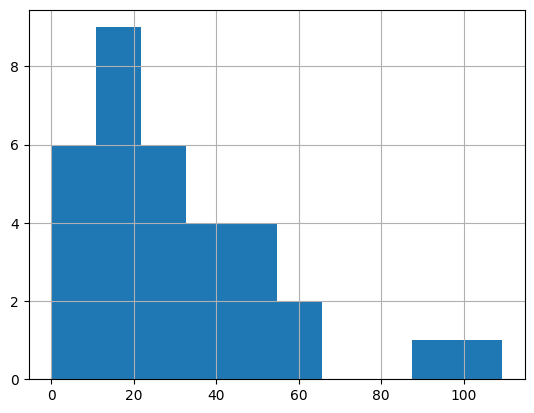

In [362]:
recent_long_term_de_contracts.hist()

<Axes: >

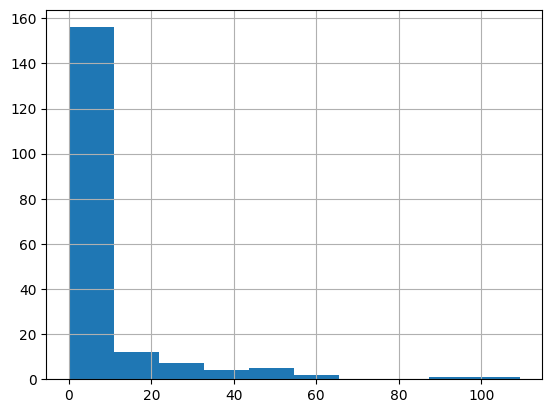

In [363]:
last_contract[(last_contract['year_signed'] > 2020)]['inflated_guaranteed'].hist()

### 5) Evaluate a predictive model for Trey

In [364]:
# Fill in missing data from pro football reference
# We're missing data for 'def_qb_hits' before the year of 2006 so leave that out
COMPARISON_FEATURES = ['player_id', 'season', 'player_display_name', 'age', 'def_sacks', 'def_tackles']
player_stats = ['def_sacks', 'def_tackles']
TREY_INDEX = (TREY_HENDRICKSON_ID, 'Trey Hendrickson')
trey_cluster_player_ids = set([player[0] for player in trey_cluster_players])

trey_df = def_df.reset_index()[COMPARISON_FEATURES]
trey_df = trey_df[trey_df['player_id'].isin(trey_cluster_player_ids)]

# This was data I manually filled in from Pro Football Reference since NFLVerse is missing data pre-1999
extra_df = pd.read_csv('./extra_player_data.csv')
# trey_df.to_csv('./trey_hendrickson_comparators.csv') # csv for some debugging
trey_df = pd.concat([trey_df, extra_df], ignore_index=True)

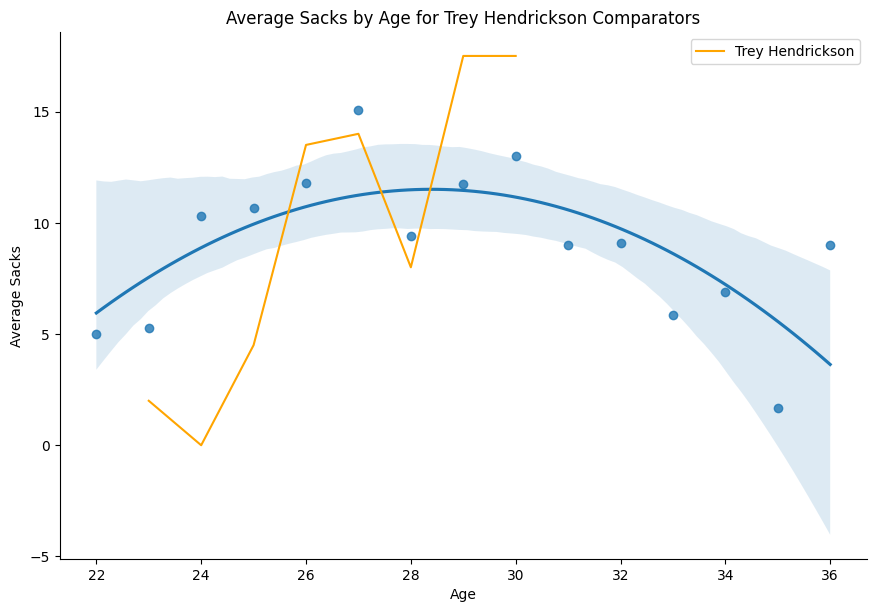

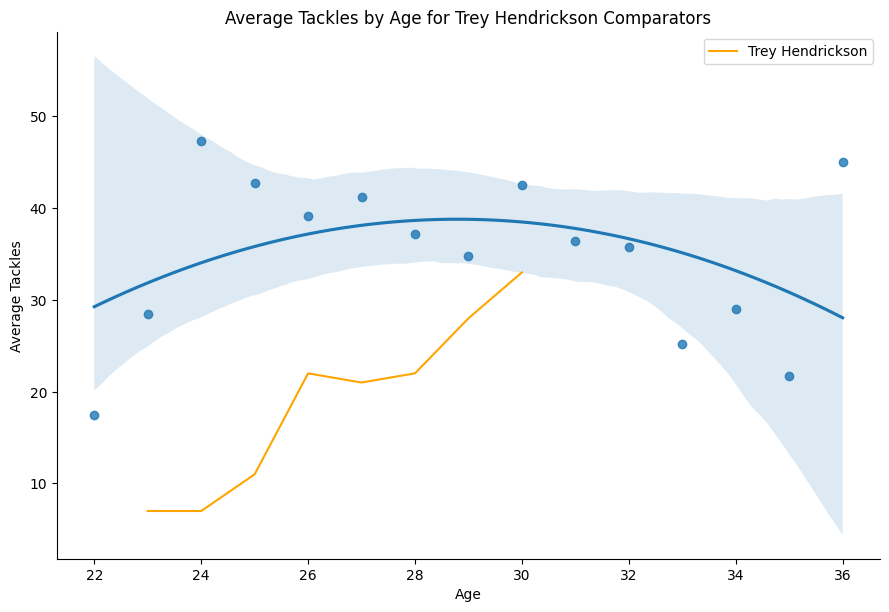

In [365]:
# pivot trey_df to have age as columns and average the stats for each player into one row
trey_pivoted_df = trey_df.pivot_table(index=['player_id', 'player_display_name'], columns='age', aggfunc={'def_sacks': 'mean', 'def_tackles': 'mean'}, values=player_stats)
without_trey = trey_pivoted_df.drop(index=TREY_INDEX, axis=1)

stat_labels = {
    'def_sacks': 'Sacks',
    'def_tackles': 'Tackles'
    }

# for each stat plot the stat for each player in the trey cluster by age
for stat in player_stats:
    mean_stat = without_trey[stat].mean()
    plot_df = {'x': mean_stat.index, 'y': mean_stat.values}
    facetgrid = sns.lmplot(data=pd.DataFrame(plot_df),x='x', y='y', order=2,height=6, aspect=1.5)
    sns.lineplot(data=trey_pivoted_df.loc[TREY_INDEX][stat], color='orange', label='Trey Hendrickson')
    plt.title(f'Average {stat_labels[stat]} by Age for Trey Hendrickson Comparators')
    plt.xlabel('Age')
    plt.ylabel(f'Average {stat_labels[stat]}')




### 5b) Actual Predictions

I used R (See player_comparison.R) to generate prediction intervals for both sacks and tackles. Those values (rounded to nearest half for sacks) are:

| Age | Sacks | Tackles |
| ---|---|---|
31 | 4-17 | 18-58|
32 | 3.5-16 | 17-57|
33 | 2.5 - 15| 15-55|
34 | 1 - 13.5 | 13-54|
35 | 0-12 | 9-52|
36 | 0-10.5 | 5-51|